# Agentic Feature Extraction Analysis for Computer Hardware Products

This notebook analyzes the performance and efficiency of the Agentic Feature Extractor when applied to computer hardware products. The goal is to optimize the extraction process by understanding the impact of each step, especially the `generate_missing_features` function, and to identify opportunities for improvement.




---



## Table of Contents

1. [Setup and Imports](#1)
2. [Testing Helper Services](#2)
    - [Weaviate Service Test](#2.1)
    - [Tavily Search Service Test](#2.2)
3. [Data Loading and Preparation](#3)
4. [Feature Extraction Test](#4)
5. [Detailed Breakdown of Extraction Stages](#5)
    - [Usage Data Preparation](#5.1)
    - [Cumulative Metrics Calculation](#5.2)
6. [Visualization and Analysis](#6)
    - [Cumulative Cost Across Stages](#6.1)
    - [Cumulative Time Across Stages](#6.2)
    - [Missing Features Across Stages](#6.3)
    - [Correlation Between Cost and Missing Features](#6.4)
7. [Optimizing `generate_missing_features`](#7)
    - [Analyzing Value Added by Each Attempt](#7.1)
    - [Optimization Recommendations](#7.2)
8. [Reusable Functions](#8)
9. [Conclusion](#9)



---



## 1. Setup and Imports <a id="1"></a>


In [1]:
import os
import sys
import json
import logging
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display
from IPython.core.interactiveshell import InteractiveShell

# Set up project root and import custom modules
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from config import Config
from prompts import PromptManager
from services import OpenAIService, TavilyService, WeaviateService
from feature_extraction import AgenticFeatureExtractor, ConfigSchema

# Load configuration and initialize services
config = Config()

# Set up display options and styles
sns.set_style("whitegrid")
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)
InteractiveShell.ast_node_interactivity = 'all'

# Configure logging
logging.basicConfig(level=logging.INFO, force=True)


---


## 2. Testing Helper Services <a id="2"></a>



Before proceeding with the main analysis, we test individual helper services to ensure they function correctly.



### 2.1 Weaviate Service Test <a id="2.1"></a>


In [8]:
async def test_weaviate_service():
    async with WeaviateService(config.OPENAI_API_KEY, config.WEAVIATE_URL) as weaviate_service:
        await weaviate_service.initialize_weaviate(True)
        product_id = "test_product_1"
        raw_data = "This is a test product with some features."

        # Test storing raw data
        raw_data_id = await weaviate_service.store_raw_data(product_id, raw_data)
        print(f"Stored raw data with ID: {raw_data_id}")

        # Test retrieving raw data
        retrieved_raw_data = await weaviate_service.get_raw_product_data(product_id)
        print(f"Retrieved raw data: {retrieved_raw_data}")

        # Test storing search results
        search_result_id = await weaviate_service.store_search_results(
            product_id, "test query", "This is a test search result", "test_source.com"
        )
        print(f"Stored search result with ID: {search_result_id}")

        # Test retrieving search results
        search_results = await weaviate_service.get_search_results(product_id)
        print(f"Retrieved search results: {search_results}")

        # Test getting relevant chunks
        chunks = await weaviate_service.get_relevant_chunks(product_id, "test query", limit=2)
        print(f"Retrieved relevant chunks: {chunks}")

        # Clean up test data
        await weaviate_service.delete_product_data(product_id)
        print("Cleaned up test data")

await test_weaviate_service()


INFO:httpx:HTTP Request: GET http://localhost:8080/v1/.well-known/openid-configuration "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/meta "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://pypi.org/pypi/weaviate-client/json "HTTP/1.1 200 OK"
INFO:services.weaviate_service:Initializing Weaviate...
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/schema "HTTP/1.1 200 OK"
INFO:weaviate_interface.schema_manager:Class mismatch: existing {'ProductSearchResult', 'RawProductData'}, expected {'Route', 'ProductDataChunk', 'ProductSearchResult', 'RawProductData', 'Product'}
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/schema "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: DELETE http://localhost:8080/v1/schema/RawProductData "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: DELETE http://localhost:8080/v1/schema/ProductSearchResult "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/schema "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST 

Stored raw data with ID: 329ac065-ed5d-47c5-b113-bdfcaf19ae8e
Retrieved raw data: {'raw_data': 'This is a test product with some features.', 'product_id': 'test_product_1'}


INFO:httpx:HTTP Request: POST http://localhost:8080/v1/objects "HTTP/1.1 200 OK"
INFO:weaviate_interface.weaviate_client:Object inserted with UUID: 61fbdf0f-5cb1-45bc-a563-5cd66247a25e
INFO:weaviate_interface.weaviate_client:Batch insert completed. 1 objects inserted.


Stored search result with ID: 531ba245-b76c-4b08-950f-6a329bb9c744
Retrieved search results: [{'data_source': 'test_source.com', 'search_result': 'This is a test search result', 'search_query': 'test query', 'product_id': 'test_product_1'}]
Retrieved relevant chunks: [{'source_type': 'search_result', 'chunk_text': 'This is a test search result', 'distance': 0.6253372430801392, 'certainty': 0.6873313784599304}, {'source_type': 'raw_data', 'chunk_text': 'This is a test product with some features.', 'distance': 0.702864408493042, 'certainty': 0.648567795753479}]
Cleaned up test data


### 2.2 Tavily Search Service Test <a id="2.2"></a>


In [2]:
async def test_tavily_search():
    async with TavilyService(config.TAVILY_API_KEY) as tavily_service:
        query = (
            "ADVENTECH PCE by ADVENTECH, form factor HALF-SIZE SYSTEM HOST BOARD, "
            "processor architecture INTEL XEON, CORE III, PENTIUM, CELERON. "
            "Find product specs: processor_tdp, wireless, operating_system_bsp, "
            "operating_temperature_max, operating_temperature_min."
        )
        exclude_domains = ["https://www.advantech.com"]
        results = await tavily_service.search(query, exclude_domains=exclude_domains)
        return results

results = await test_tavily_search()
for result in results:
    print(len(result["search_result"]))


INFO:services.tavily_service:Normalized exclude domains: {'https://www.advantech.com'}
ERROR:services.tavily_service:Error in Tavily search (attempt 1/3): The provided API key is invalid.
ERROR:services.tavily_service:Error in Tavily search (attempt 2/3): The provided API key is invalid.


CancelledError: 

---


## 3. Data Loading and Preparation <a id="3"></a>



We load the raw data for the product we want to analyze.


In [4]:
# Load the specific product data
products_df = pd.read_csv("../data/feature_extraction/processed_products_df.csv")
raw_data = products_df[products_df["id"] == "HPC-7400MB-70A1E"].copy()
raw_data.head()

# 102110644
# PCE-3028G2-00A1E

,id,raw_data,raw_length,duplicate_ids
34,HPC-7400MB-70A1E,Server Chassis Features HPC U Compact Rackmount Tower Chassis EATXATXMicroATX Motherboard U compact industrial server chassis suitable spacesensitive applications Supports EATXATXMicroATX motherboard Shockresistant x front x int rear optional x int HDD bays Supports plus U single redundant higher watt power supply Frontaccessible system fan without opening top cover Lockable front door replaceable air filter prevents unauthorized access Specifications Drive Bay Frontaccessible Internal rearaccessible Cooling Fan cm CFM PWM fans optional cm rear fans Air Filter Yes Front IO Interface USB USB Miscellaneous LED Indicators Power HDD LAN LAN Control Power switch system reset button Environment Operating NonOperating Temperature C F C F Humidity C noncondensing C noncondensing Vibration Hz Grms G Shock G ms duration half sine wave Physical Characteristics Dimensions W x H x D x x mm x x Weight kg Front View Inside View Rear View Tower View With W single power supply With W redundant power supply All product specifications subject change without notice Last updated Jun wwwadvantechcomproductsOnline Download Dimensions Unit mm HPC Ordering Information Part Number Power Supply HPCMBAE With single W power supply ATX switch HPCMBAE With redundant W power supply ATX switch Packing List Part Number Description Quantity T Door filter cm system fan PSAWU U W single power supply AC V full range HPCMBAE PSRMAKWMDU U W redundant power module AC V full range HPCMBAE PSRUBKPFK W power distribution board PSRMAKWMDU HPCMBAE Optional Accessories Part Number Description IPCDTE Mobile rack converting dual drive bays three SASSATA HDD Trays RACKSSCAGECR Mobile rack converting one drive bays four SATASAS HDD Trays Max HDD height mm E Module convert one drive bay one slim ODD one internal drive bay Slide Rail Front dual USB cable kit mm High speed system fan GPU server solution Note HPC support AIMB series motherboards HPC support addon cards need connected additional power cables top HPC support N due mechanical limitations,312,['HPC-7400MB-70A1E']



---


## 4. Feature Extraction Test <a id="4"></a>



We perform feature extraction on the selected product using the `AgenticFeatureExtractor`.


In [5]:
async def test_feature_extraction(data,
                                  model_name="gpt-4o",
                                  max_missing_feature_attempts=3,
                                  max_low_confidence_attempts=3,
                                  confidence_threshold=0.7):
    async with OpenAIService(config.OPENAI_API_KEY, config) as openai_service, \
               TavilyService(config.TAVILY_API_KEY) as tavily_service, \
               WeaviateService(config.OPENAI_API_KEY, config.WEAVIATE_URL) as weaviate_service:

        services = {
            "openai_service": openai_service,
            "tavily_service": tavily_service,
            "weaviate_service": weaviate_service
        }

        prompt_manager = PromptManager()

        feature_extraction = AgenticFeatureExtractor(
            services,
            prompt_manager,
            config=ConfigSchema(
                model_name=model_name,
                max_missing_feature_attempts=max_missing_feature_attempts,
                max_low_confidence_attempts=max_low_confidence_attempts,
                confidence_threshold=confidence_threshold
            )
        )

        # Visualize the workflow
        display(Image(feature_extraction.workflow.get_graph().draw_mermaid_png()))

        result = await feature_extraction.extract_data(data["raw_data"], data["id"])

        return result

INFO:httpx:HTTP Request: GET http://localhost:8080/v1/.well-known/openid-configuration "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/meta "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://pypi.org/pypi/weaviate-client/json "HTTP/1.1 200 OK"
INFO:feature_extraction.agentic_feature_extractor:Required features: {'name': 'The official name of the product.', 'manufacturer': 'The company that produces the product.', 'form_factor': "The single, primary physical form factor or standard of the product (e.g., 'ATX', 'Mini-ITX', 'Raspberry Pi').", 'evaluation_or_commercialization': 'Indicates if the product is for evaluation or commercial use (True for evaluation, False for commercial).', 'processor_architecture': 'The architecture of the processor (e.g., ARM, x86).', 'processor_core_count': 'The number of cores in the processor.', 'processor_manufacturer': 'The company that manufactures the processor.', 'processor_tdp': 'The Thermal Design Power of the proce

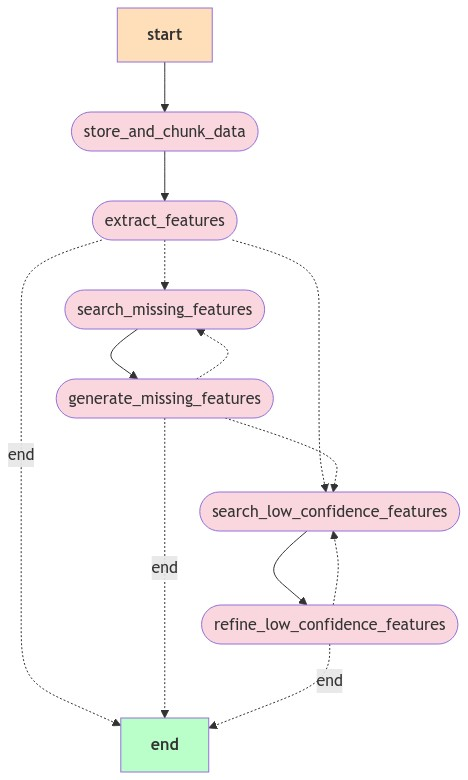

INFO:feature_extraction.agentic_feature_extractor:Starting feature extraction workflow.
INFO:feature_extraction.agentic_feature_extractor:Storing and chunking raw data.
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/objects "HTTP/1.1 200 OK"
INFO:weaviate_interface.weaviate_client:Object inserted with UUID: 64b936f2-7858-451f-86de-9f49589ab3cc
INFO:services.weaviate_service:Storing 1 chunks for product HPC-7400MB-70A1E
INFO:weaviate_interface.weaviate_client:Inserting 1 objects into collection ProductDataChunk
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/objects "HTTP/1.1 200 OK"
INFO:weaviate_interface.weaviate_client:Object inserted with UUID: 22569355-9fba-4d6a-a73e-791d70553486
INFO:weaviate_interface.weaviate_client:Batch insert completed. 1 objects inserted.
INFO:feature_extraction.agentic_feature_extractor:Starting feature extraction.
INFO:feature_extraction.agentic_feature_extractor:Retrieved 1 relevant chunks
INFO:httpx:HTTP Request: POST https://api.openai.c

CancelledError: 

In [6]:
# Run the feature extraction test
result = await test_feature_extraction(raw_data.iloc[0], max_missing_feature_attempts=5)

In [ ]:
result

{'extracted_data': {'name': 'HPC U COMPACT RACKMOUNT TOWER CHASSIS',
  'manufacturer': 'ADVANTECH',
  'form_factor': 'RACKMOUNT TOWER',
  'evaluation_or_commercialization': False,
  'processor_architecture': 'Not Available',
  'processor_core_count': 'Up to 24 cores',
  'processor_manufacturer': 'Intel',
  'processor_tdp': 'Not Available',
  'memory': 'Up to 128 GB DDR5 5600',
  'onboard_storage': 'Not Available',
  'input_voltage': 'AC 100-240V',
  'io_count': 'USB 2.0, USB 3.0',
  'wireless': 'Not Available',
  'operating_system_bsp': 'Not Available',
  'operating_temperature_max': '60°C',
  'operating_temperature_min': '0°C',
  'certifications': 'Not Available',
  'short_summary': 'Compact industrial server chassis for space-sensitive applications with support for EATX, ATX, and MicroATX motherboards.',
  'full_summary': 'The HPC U Compact Rackmount Tower Chassis is designed for industrial applications requiring a compact form factor. It supports EATX, ATX, and MicroATX motherboards



---



## 5. Detailed Breakdown of Extraction Stages <a id="5"></a>



We analyze the usage data to understand the performance and cost implications of each extraction stage.



### 5.1 Usage Data Preparation <a id="5.1"></a>


In [ ]:
# Constants for pricing (Assuming GPT-4o pricing)
INPUT_TOKEN_COST  = 0.0000025
OUTPUT_TOKEN_COST = 0.00001

In [ ]:
def flatten_usage_data(usage):
    usage_records = []
    for step, usages in usage.items():
        for idx, usage_entry in enumerate(usages, 1):
            record = {
                "Step": f"{step} ({idx})",
                "input_tokens": usage_entry["input_tokens"],
                "output_tokens": usage_entry["output_tokens"],
                "time_taken": usage_entry["time_taken"],
            }
            # Calculate cost
            input_cost = usage_entry["input_tokens"] * INPUT_TOKEN_COST
            output_cost = usage_entry["output_tokens"] * OUTPUT_TOKEN_COST
            total_cost = input_cost + output_cost
            record["cost"] = total_cost
            usage_records.append(record)
    return pd.DataFrame(usage_records)

# Flatten the usage data
usage_df = flatten_usage_data(result["usage"])
usage_df

,Step,input_tokens,output_tokens,time_taken,cost
0,store_and_chunk_data (1),0,0,2.21,0.00
1,generate_missing_features (1),3758,236,5.73,0.01
2,generate_missing_features (2),3864,150,4.43,0.01
3,generate_missing_features (3),3843,150,4.86,0.01
4,search_missing_features (1),258,46569,18.52,0.47
5,search_missing_features (2),204,137701,18.00,1.38
6,search_missing_features (3),204,137573,21.25,1.38
7,extract_features (1),1107,711,8.43,0.01


### 5.2 Cumulative Metrics Calculation <a id="5.2"></a>


In [ ]:
# Extract relevant steps for analysis
extraction_df = usage_df[usage_df["Step"].str.contains("extract_features|generate_missing_features")].copy()

# Rename and reorder steps
def map_step(step):
    if 'extract_features' in step:
        return 'Extract'
    elif 'generate_missing_features' in step:
        attempt = step.split('(')[-1].split(')')[0]
        return f'Attempt {attempt}'
    return step

extraction_df['Step'] = extraction_df['Step'].apply(map_step)

# Sort steps
extraction_df = extraction_df.sort_values('Step', key=lambda x: pd.Categorical(x, ['Extract'] + [f'Attempt {i}' for i in range(1, len(extraction_df))]))
extraction_df["missing_features"] = result["missing_feature_count_history"][: extraction_df.shape[0]]

# Calculate cumulative metrics
extraction_df["cumulative_time"] = extraction_df["time_taken"].cumsum()
extraction_df["cumulative_cost"] = extraction_df["cost"].cumsum()
extraction_df["cumulative_input_tokens"] = extraction_df["input_tokens"].cumsum()
extraction_df["cumulative_output_tokens"] = extraction_df["output_tokens"].cumsum()

extraction_df

,Step,input_tokens,output_tokens,time_taken,cost,missing_features,cumulative_time,cumulative_cost,cumulative_input_tokens,cumulative_output_tokens
7,Extract,1107,711,8.43,0.01,9,8.43,0.01,1107,711
1,Attempt 1,3758,236,5.73,0.01,6,14.16,0.02,4865,947
2,Attempt 2,3864,150,4.43,0.01,6,18.59,0.03,8729,1097
3,Attempt 3,3843,150,4.86,0.01,6,23.45,0.04,12572,1247




---


## 6. Visualization and Analysis <a id="6"></a>

We visualize the cumulative cost, time, and missing features across extraction stages to identify patterns and opportunities for optimization.


### 6.1 Cumulative Cost Across Stages <a id="6.1"></a>


In [ ]:
def plot_cumulative_metric(df, x_col, y_col, title, y_label, value_format=".3f", value_prefix="$"):
    plt.figure(figsize=(12, 7))

    # Calculate step-specific values and percentage increases
    df['step_value'] = df[y_col].diff().fillna(df[y_col])
    df['percent_increase'] = df[y_col].pct_change().fillna(0) * 100

    # Create the cumulative bar plot
    ax = sns.barplot(data=df, x=x_col, y=y_col, palette="viridis")

    # Add value labels for cumulative and step-specific values
    for i, (cum_value, step_value, pct_increase) in enumerate(zip(df[y_col], df['step_value'], df['percent_increase'])):
        # Cumulative value
        plt.text(i, cum_value, f"{value_prefix}{cum_value:{value_format}}",
                 ha='center', va='bottom', fontweight='bold', fontsize=12)

        # Step-specific value and percentage increase
        if i > 0:
            sign = "-" if step_value < 0 else "+"
            plt.text(i, cum_value/2, f"{sign}{value_prefix}{abs(step_value):{value_format}}\n({sign}{abs(pct_increase):.1f}%)",
                     ha='center', va='center', fontweight='bold', fontsize=14, color='white')

    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel("Extraction Stage", fontsize=12, fontweight='bold', labelpad=10)
    plt.ylabel(y_label, fontsize=12, fontweight='bold', labelpad=10)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)

    # Add a grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

/var/folders/rp/6b0gnlkd7cl_wvl_lj9y8nx40000gn/T/ipykernel_37310/2765523291.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x=x_col, y=y_col, palette="viridis")


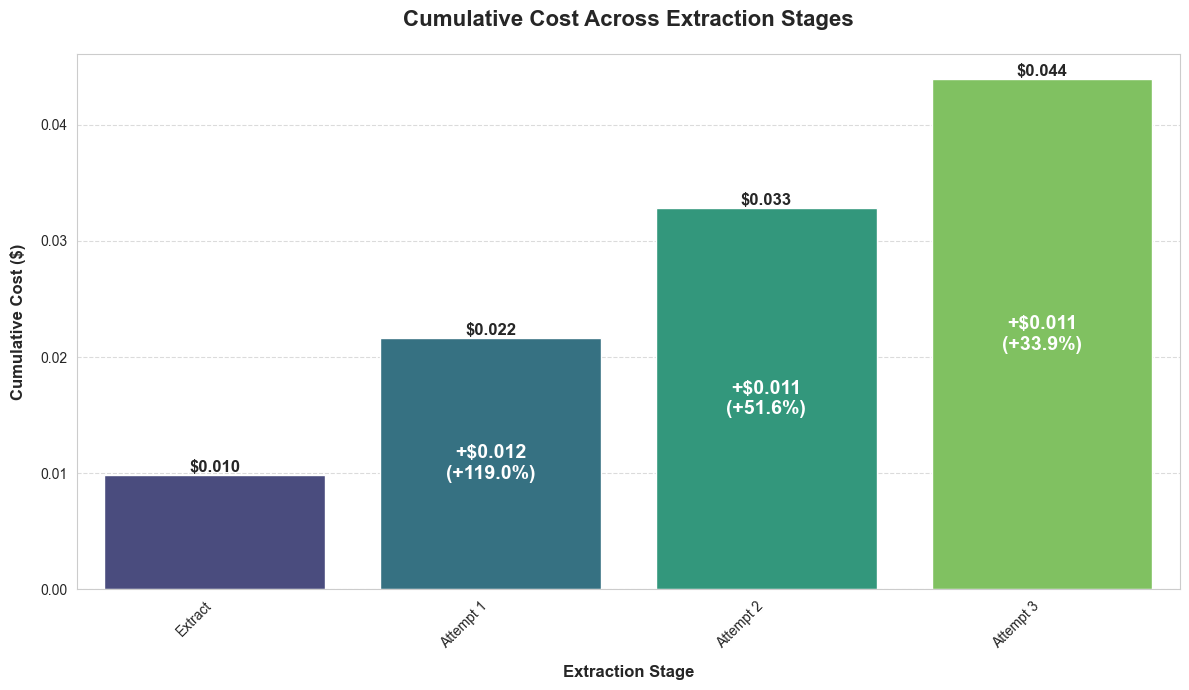

In [ ]:

plot_cumulative_metric(
    extraction_df,
    "Step",
    "cumulative_cost",
    "Cumulative Cost Across Extraction Stages",
    "Cumulative Cost ($)"
)


In [ ]:
0.061*1600

97.6

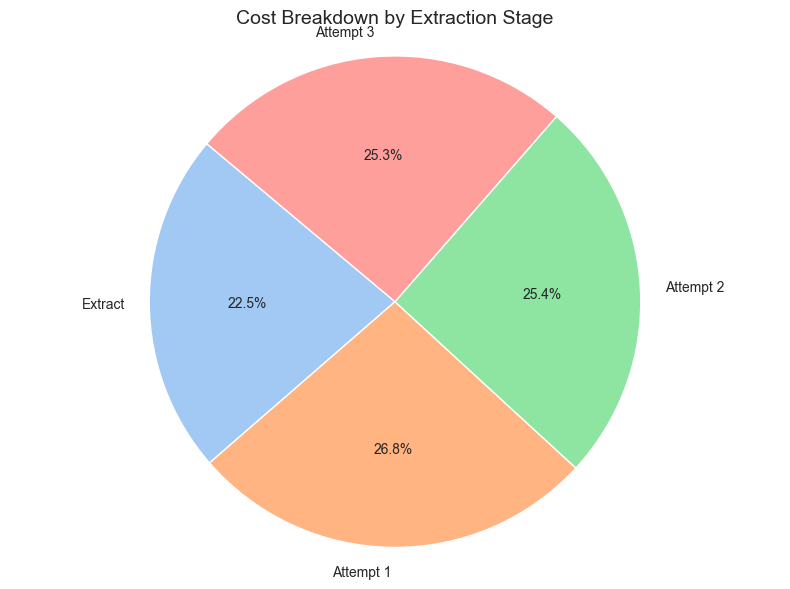

In [ ]:
def plot_cost_breakdown(df):
    plt.figure(figsize=(8, 6))
    plt.pie(
        df["cost"],
        labels=df["Step"],
        autopct="%1.1f%%",
        startangle=140,
        colors=sns.color_palette("pastel")[0 : len(df)],
    )
    plt.title("Cost Breakdown by Extraction Stage", fontsize=14)
    plt.axis("equal")
    plt.tight_layout()
    plt.show()


plot_cost_breakdown(extraction_df)

### 6.2 Cumulative Time Across Stages <a id="6.2"></a>


/var/folders/rp/6b0gnlkd7cl_wvl_lj9y8nx40000gn/T/ipykernel_37310/2765523291.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x=x_col, y=y_col, palette="viridis")


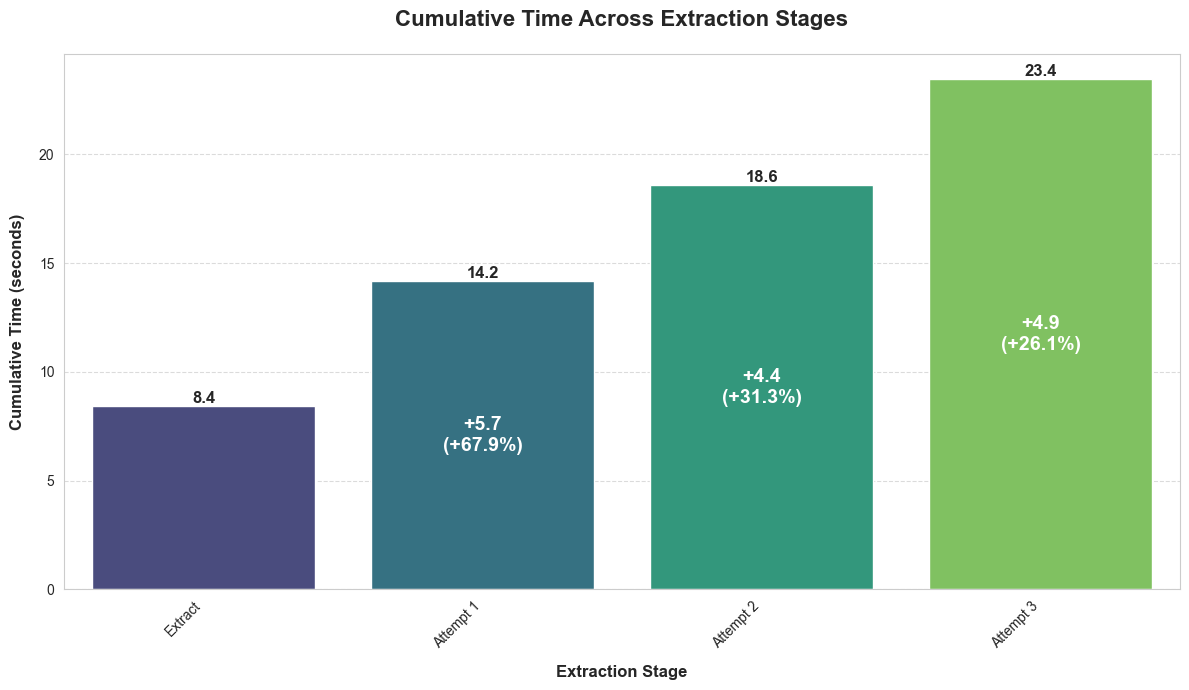

In [ ]:
plot_cumulative_metric(
    extraction_df,
    "Step",
    "cumulative_time",
    "Cumulative Time Across Extraction Stages",
    "Cumulative Time (seconds)",
    value_format=".1f",
    value_prefix=""
)


### 6.3 Missing Features Across Stages <a id="6.3"></a>


/var/folders/rp/6b0gnlkd7cl_wvl_lj9y8nx40000gn/T/ipykernel_37310/2765523291.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x=x_col, y=y_col, palette="viridis")


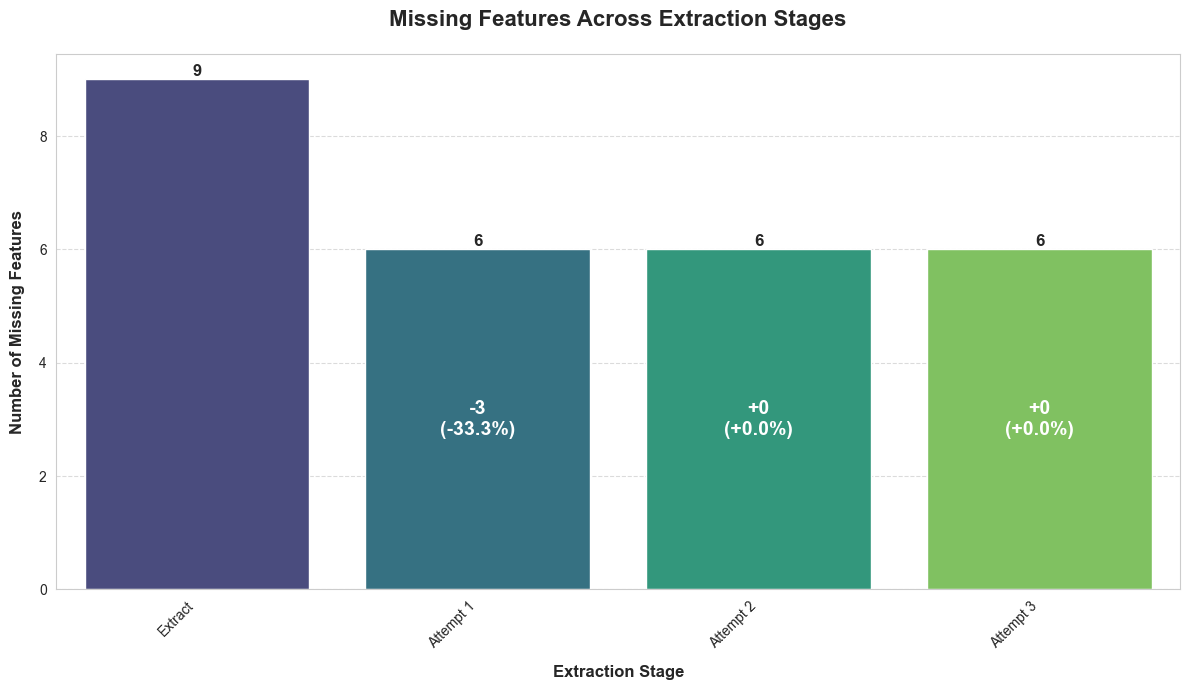

In [ ]:

plot_cumulative_metric(
    extraction_df,
    "Step",
    "missing_features",
    "Missing Features Across Extraction Stages",
    "Number of Missing Features",
    value_format=".0f",
    value_prefix=""
)




### 6.4 Correlation Between Cost and Missing Features <a id="6.4"></a>


In [ ]:
def plot_cost_vs_missing_features(df):
    plt.figure(figsize=(10, 6))
    sns.regplot(
        x="cumulative_cost",
        y="missing_features",
        data=df,
        scatter_kws={'s': 50},
        line_kws={'color': 'red'}
    )
    plt.title("Correlation Between Cost and Missing Features", fontsize=14)
    plt.xlabel("Cumulative Cost ($)")
    plt.ylabel("Number of Missing Features")

    # Calculate and display correlation coefficient
    corr = df["cumulative_cost"].corr(df["missing_features"])
    plt.text(0.05, 0.95, f"Correlation: {corr:.2f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

    plt.tight_layout()
    plt.show()


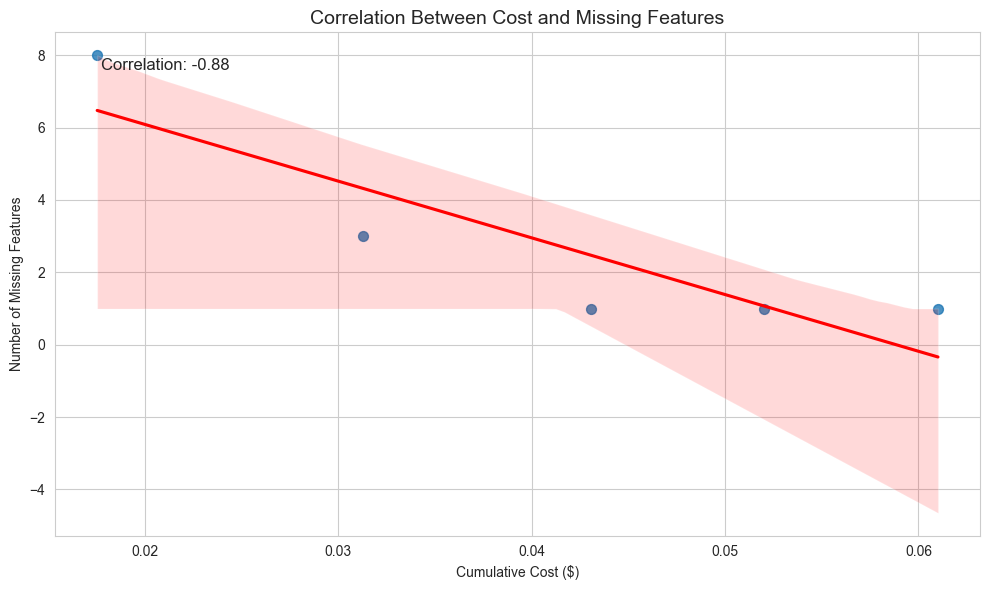

In [ ]:

plot_cost_vs_missing_features(extraction_df)

---



## 7. Optimizing `generate_missing_features` <a id="7"></a>



We analyze the effectiveness of the `generate_missing_features` function across iterations to determine the optimal number of attempts.



### 7.1 Analyzing Value Added by Each Attempt <a id="7.1"></a>


Reduction in Missing Features per Attempt:


,Step,missing_features_reduction,cost_increment
9,Extract,0.00,0.02
0,Attempt 1,5.00,-0.00
1,Attempt 2,2.00,-0.00
2,Attempt 3,0.00,-0.00
3,Attempt 4,0.00,0.00


<Figure size 1000x600 with 0 Axes>

/var/folders/rp/6b0gnlkd7cl_wvl_lj9y8nx40000gn/T/ipykernel_29302/4293861875.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=extraction_df, x="Step", y="missing_features_reduction", palette="Greens_d")


<Axes: xlabel='Step', ylabel='missing_features_reduction'>

Text(0.5, 1.0, 'Reduction in Missing Features per Attempt')

Text(0.5, 0, 'Extraction Stage')

Text(0, 0.5, 'Number of Features Reduced')

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Extract'),
  Text(1, 0, 'Attempt 1'),
  Text(2, 0, 'Attempt 2'),
  Text(3, 0, 'Attempt 3'),
  Text(4, 0, 'Attempt 4')])

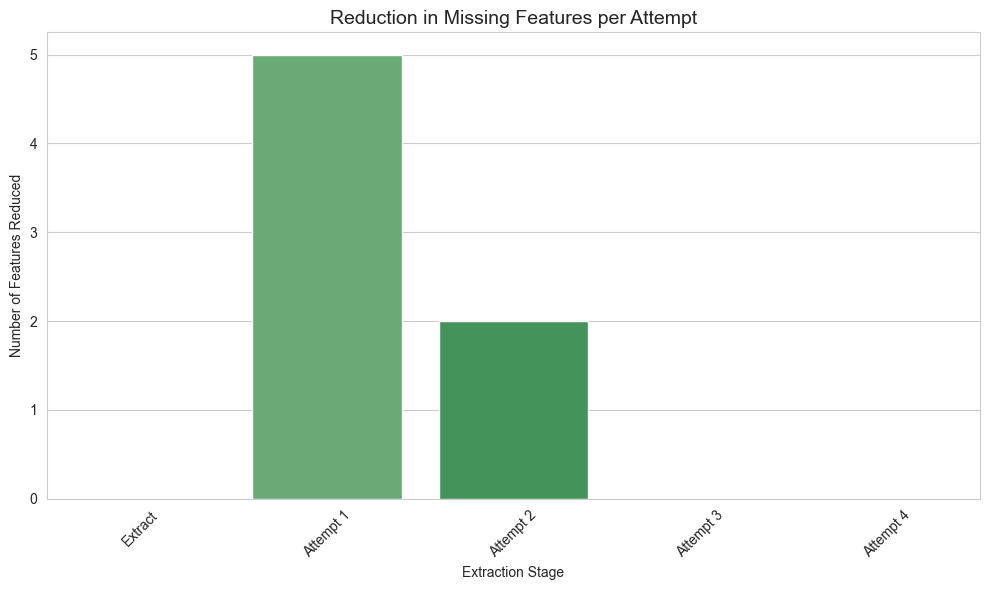

In [ ]:
# Calculate the reduction in missing features after each attempt
extraction_df["missing_features_reduction"] = extraction_df["missing_features"].diff().abs().fillna(0)
extraction_df["cost_increment"] = extraction_df["cost"].diff().fillna(extraction_df["cost"])

# Identify the point where additional attempts add minimal value
print("Reduction in Missing Features per Attempt:")
display(extraction_df[["Step", "missing_features_reduction", "cost_increment"]])

# Plot missing features reduction per attempt
plt.figure(figsize=(10, 6))
sns.barplot(data=extraction_df, x="Step", y="missing_features_reduction", palette="Greens_d")
plt.title("Reduction in Missing Features per Attempt", fontsize=14)
plt.xlabel("Extraction Stage")
plt.ylabel("Number of Features Reduced")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


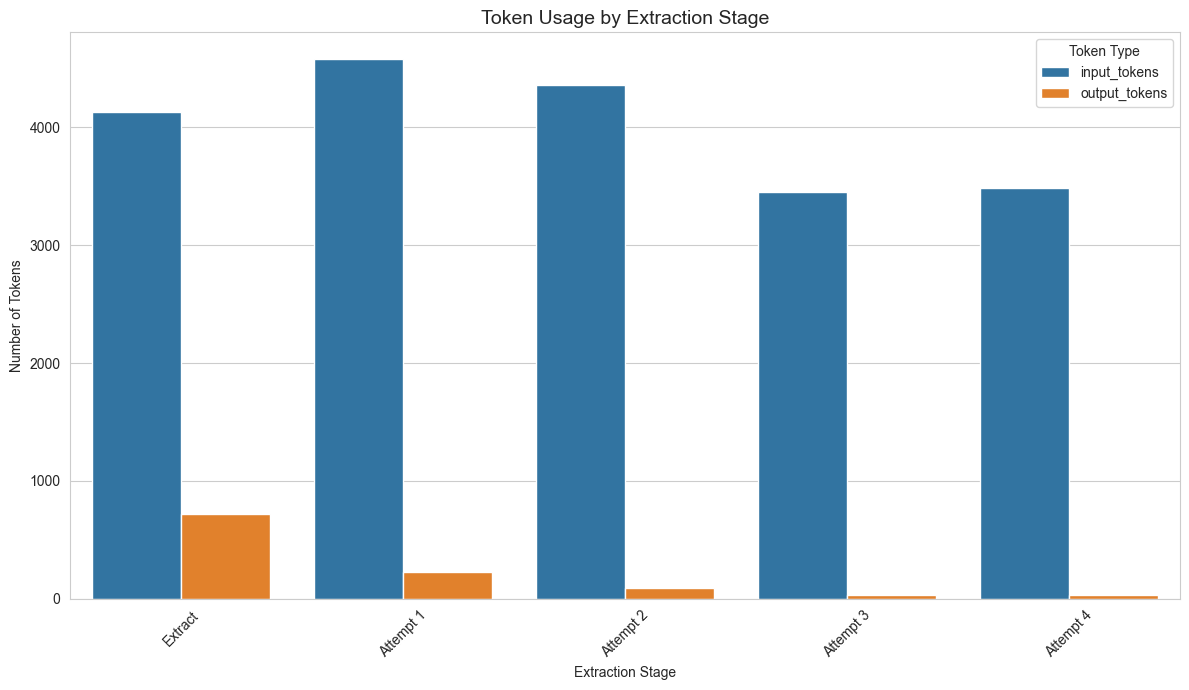

In [ ]:
def plot_token_usage(df):
    plt.figure(figsize=(12, 7))
    df_melted = df.melt(
        id_vars="Step", value_vars=["input_tokens", "output_tokens"], var_name="Token Type", value_name="Tokens"
    )
    sns.barplot(data=df_melted, x="Step", y="Tokens", hue="Token Type")
    plt.title("Token Usage by Extraction Stage", fontsize=14)
    plt.xlabel("Extraction Stage")
    plt.ylabel("Number of Tokens")
    plt.xticks(rotation=45)
    plt.legend(title="Token Type")
    plt.tight_layout()
    plt.show()


plot_token_usage(extraction_df)

### 7.2 Optimization Recommendations <a id="7.2"></a>

From the analysis, we observe diminishing returns after a certain number of `generate_missing_features` attempts.


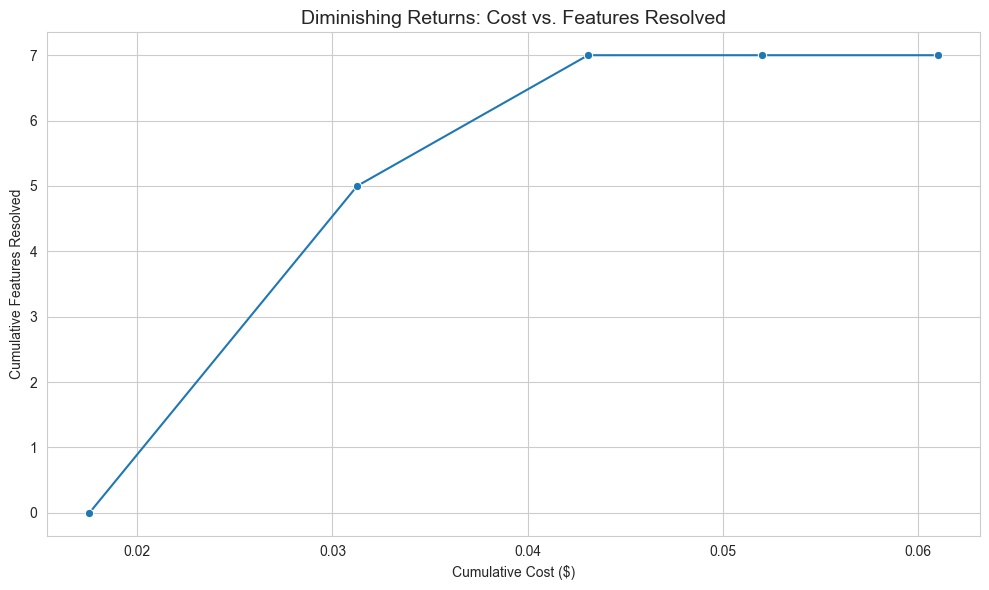

In [ ]:
# Calculate cumulative missing features resolved
extraction_df["cumulative_features_resolved"] = extraction_df["missing_features_reduction"].cumsum()


# Plot
def plot_diminishing_returns(df):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x="cumulative_cost", y="cumulative_features_resolved", marker="o")
    plt.title("Diminishing Returns: Cost vs. Features Resolved", fontsize=14)
    plt.xlabel("Cumulative Cost ($)")
    plt.ylabel("Cumulative Features Resolved")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_diminishing_returns(extraction_df)

---


## 8. Conclusion <a id="9"></a>

The analysis shows that while additional iterations of `generate_missing_features` reduce the number of missing features, the value added diminishes after a certain point. By optimizing the `max_missing_feature_attempts` parameter based on the cost-benefit analysis, we can improve the efficiency of the Agentic Feature Extractor without significantly compromising data quality.

---


In [ ]:
# Convert notebook to HTML
from nbconvert import HTMLExporter
import nbformat

# Read the notebook
with open("./2.2 agentic_feature_extraction.ipynb", "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

# Create an HTML exporter
html_exporter = HTMLExporter()
html_exporter.template_name = "classic"

# Convert the notebook to HTML
(body, resources) = html_exporter.from_notebook_node(nb)

# Write the HTML to a file
with open("2.2 agentic_feature_extraction_error.html", "w", encoding="utf-8") as f:
    f.write(body)

print("Notebook has been converted to HTML and saved as '2.2 agentic_feature_extraction_error.html'")

1282254

Notebook has been converted to HTML and saved as '2.2 agentic_feature_extraction_error.html'
